In [8]:
import tempfile
import subprocess
from IPython.display import Image, display
from time import time

In [9]:
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_pydot(description):
    with tempfile.NamedTemporaryFile(mode="w") as tmp1:
        tmp1.write(description)
        tmp1.flush()
        bashCommand = f"dot -Tpng {tmp1.name}"
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        display(Image(output))
        
def add_marker(text):
    return text + '$'

## Klasa węzła

In [10]:
class Node:
    counter = 1
    
    def __init__(self, label, depth, start_index=None, end_index=None, parent=None):
        self.children = {}
        
        self.start_index = start_index
        self.end_index = end_index
        self.parent = parent
        
        self.label = label
        self.link = None
        self.id = Node.counter
        self.depth = depth
        Node.counter += 1
        
    def dot_node(self):
        return f'{self.id} [label="", shape="point"];'
        
    def dot_edges(self, links=True):
        result = []
        for child in self.children.values():
            result.append(f'{self.id} -> {child.id}[arrowhead="none", label=" {child.label}"];')
        if self.link and links:
            result.append(f'{self.id} -> {self.link.id}[color="blue"];')
        return "\n".join(result)
    
    def all_children(self, only_leafs=False):
        if(not only_leafs or not self.children):
            result = [self]
        else:
            result = []
        for child in self.children.values():
            result += child.all_children(only_leafs=only_leafs)
        return result
    
    def show(self, links=True):
        nodes = self.all_children()
        Node.show_graph(nodes, links=links)
    
    @staticmethod
    def show_graph(nodes, links=True):
        result = "digraph{\n"
        ranks = {}
        for node in nodes:
            result += node.dot_node() + "\n"
            result += node.dot_edges(links) + "\n"
            if(node.depth not in ranks):
                ranks[node.depth] = []
            ranks[node.depth].append(node.id)
        for key, values in ranks.items():
            values = " ".join([f"{v};" for v in values])
            result += " { rank=same; " + values + "}\n"
        result += "\n}"
        show_pydot(result)

## Drzewo trie

In [11]:
class Trie:
    def __init__(self, text):
        self.text = add_marker(text)
        self.text_length = len(self.text)
        self.root = Node("", 0)        
        self.build_trie()

    def build_trie(self):
        for suffix_start_index in range(self.text_length):
            head_node = self.find_head_node(suffix_start_index)
            self.graft_new_path(head_node, suffix_start_index)


    def find_head_node(self, index):
        node = self.root
        current_letter = self.text[index]
        while current_letter in node.children:
            node = node.children[current_letter]
            index += 1
            current_letter = self.text[index]
        return node


    def graft_new_path(self, node, index):
        current_index = index + node.depth

        while current_index < self.text_length:
            current_letter = self.text[current_index]
            node.children[current_letter] = Node(current_letter, node.depth+1)
            node = node.children[current_letter]
            current_index += 1
        
    def is_pattern_in_text(self, pattern):
        node = self.root
        index = 0
        pattern_len = len(pattern)
        while pattern[index] in node.children:
            node = node.children[pattern[index]]
            index += 1
            if index == pattern_len:
                return True
        return False

## Drzewo sufiksów

In [401]:
class SuffixTree:
    def __init__(self, text):
        self.text = add_marker(text)
        self.root = Node('', 0, None, None)
        self.last_text_index = len(self.text)-1
        self.build_tree()
    
    def build_tree(self):
        for cur_suffix_index in range(self.last_text_index, -1, -1):
            head, graft_index, move = self.find_head(cur_suffix_index)
            self.graft_new_path(head, graft_index, cur_suffix_index, move)

    
    def find_head(self, cur_suffix_index):
        cur_node = self.root
        move = 0
        while cur_suffix_index < self.last_text_index and self.text[cur_suffix_index] in cur_node.children:
            cur_node = cur_node.children[self.text[cur_suffix_index]]
            on_edge_index = cur_node.start_index
            
            while on_edge_index <= cur_node.end_index and self.text[cur_suffix_index] == self.text[on_edge_index]:
                cur_suffix_index += 1
                on_edge_index += 1
                move += 1
            
            if on_edge_index <= cur_node.end_index :
                return cur_node, on_edge_index - cur_node.start_index, move-1          
        else:
            return cur_node, 0, move
            
    def graft_new_path(self, node, graft_index, start_suffix_index, move):
        if graft_index == 0:
#             start_suffix_index= min(self.last_text_index, start_suffix_index + move)
            start_suffix_index+=move
            new_node = Node(self.text[start_suffix_index], node.depth+1, start_suffix_index, self.last_text_index, node)
            node.children[self.text[start_suffix_index]] = new_node
        else:
            print(node.label, graft_index, start_suffix_index)

            mid_index_end = node.start_index+graft_index-1
            mid_node = Node(self.text[node.start_index], node.depth, node.start_index, mid_index_end, node.parent)
            
            node.start_index = mid_node.end_index+1
            node.label = self.text[node.start_index]
            node.depth = mid_node.depth+1
            
            new_node_start = start_suffix_index+graft_index
            new_node = Node(self.text[new_node_start], mid_node.depth+1, new_node_start, self.last_text_index, mid_node)
            
            mid_node.children[new_node.label] = new_node
            mid_node.children[node.label] = node
            
            node.parent.children[mid_node.label] = mid_node
            
            node.parent = mid_node

        
    def is_pattern_in_text(self, pattern):
        node = self.root
        index = 0
        pattern_len = len(pattern)
        while pattern[index] in node.children:
            node = node.children[pattern[index]]
            on_edge_index = node.start_index
            print(pattern[index], self.text[on_edge_index])

            while index < pattern_len and on_edge_index <= node.end_index and pattern[index] == self.text[on_edge_index]:
                print(pattern[index], self.text[on_edge_index])

                index+=1
                on_edge_index+=1
                
            if index == pattern_len:
                return True            
        return False
                

## Test poprawnośći

In [391]:
def corectness_tests(Tree, texts):
    not_passed_counter = 0
    for text in texts:
        if not corectness_test(Tree, text):
            not_passed_counter+=1
    if not_passed_counter == 0:
        print("All tests passed")
    else:
        print(f'{not_passed_counter} tests not passed')
        
def corectness_test(Tree, text):
    patterns = []
    text_len = len(text)
    tree = Tree(text)
    for i in range(text_len):
        for j in range(i+1, text_len):
            if not tree.is_pattern_in_text(text[i:j]):
                print('Not found pattern:/', (i, j), '/in text:')
                patterns.append(text[i:j])
                
    if len(patterns) > 0:
        return False, patterns
    return True

In [392]:
corectness_tests(Trie, ['bbb', 'aabbabd', 'ababcd', 'abcbccd'])
corectness_tests(SuffixTree, ['ababa', 'aabbabd', 'ababcd', 'abcbccd'])

All tests passed
a 1 2
b 2 1
b 2 0
a a
a a
a a
a a
b b
b b
a a
a a
b b
b b
a a
a a
a a
b b
b b
a a
Not found pattern:/ (0, 4) /in text:
b b
b b
b b
b b
a a
b b
b b
a a
Not found pattern:/ (1, 4) /in text:
a a
a a
a a
a a
b b
b b
b b
b b
b 1 3
a 2 1
a 1 0
a a
a a
a a
a a
a a
a a
a a
a a
a a
a a
b b
a a
a a
a a
a a
b b
b b
a a
a a
a a
a a
b b
b b
a a
a a
a a
a a
a a
b b
b b
a a
b b
a a
a a
a a
a a
b b
b b
a a
a a
b b
b b
Not found pattern:/ (1, 4) /in text:
a a
a a
b b
b b
Not found pattern:/ (1, 5) /in text:
a a
a a
b b
b b
Not found pattern:/ (1, 6) /in text:
b b
b b
b b
b b
b b
b b
b b
b b
b b
b b
a a
b b
b b
b b
b b
a a
b b
b b
b b
b b
b b
a a
a a
b b
b b
a a
a a
b b
a a
a a
a a
a a
b b
b b
b b
b b
b 1 1
a 2 0
a a
a a
a a
a a
b b
a a
a a
b b
Not found pattern:/ (0, 3) /in text:
a a
a a
b b
Not found pattern:/ (0, 4) /in text:
a a
a a
b b
Not found pattern:/ (0, 5) /in text:
b b
b b
b b
b b
a a
a a
b b
b b
a a
a a
b b
b b
b b
a a
a a
b b
c c
a a
a a
a a
a a
b b
a a
a a
b b
c c
c c
b b

In [402]:
t = SuffixTree('ababa')

a 1 2
b 2 1
b 2 0


In [403]:
t.root.children['a'].children['b'].children['a'].start_index

2

In [404]:
t.is_pattern_in_text('abab')

a a
a a
b b
b b
a a


False

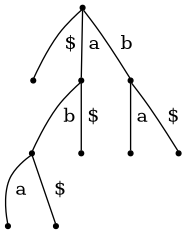

In [396]:
t.root.show()

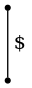

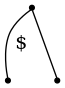

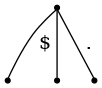

Error: /tmp/tmpuqr71h1y: syntax error in line 8 near '"'


Error: /tmp/tmp8wi3xr5l: syntax error in line 8 near 'none'


Error: /tmp/tmp75l7ojnw: syntax error in line 8 near 'none'


Error: /tmp/tmpji6_i_3e: syntax error in line 8 near 'none'


Error: /tmp/tmpozyqow5d: syntax error in line 8 near 'none'


Error: /tmp/tmpqoy74b7t: syntax error in line 8 near 'none'


o 1 2489


Error: /tmp/tmppti4pgud: syntax error in line 8 near 'none'


Error: /tmp/tmpqr82ddtx: syntax error in line 8 near 'none'


Error: /tmp/tmpof84s_q6: syntax error in line 8 near 'none'


Error: /tmp/tmp2dv7jbwc: syntax error in line 8 near 'none'


d 2 2485


Error: /tmp/tmpmxj636yr: syntax error in line 8 near 'none'



 1 2484


Error: /tmp/tmprfte9jv8: syntax error in line 8 near 'none'


Error: /tmp/tmpy5r8ki_v: syntax error in line 8 near 'none'


Error: /tmp/tmp18ptzj9m: syntax error in line 8 near 'none'


Error: /tmp/tmpu8v_2010: syntax error in line 8 near 'none'


Error: /tmp/tmpm3d0qfc6: syntax error in line 8 near 'none'


d 1 2479


Error: /tmp/tmpr10mm6te: syntax error in line 8 near 'none'


Error: /tmp/tmp9q2pbrbo: syntax error in line 8 near 'none'


Error: /tmp/tmpz7x68l6n: syntax error in line 8 near 'none'


Error: /tmp/tmpd5z3zid3: syntax error in line 8 near 'none'


Error: /tmp/tmpfxdendb8: syntax error in line 8 near 'none'


  1 2474


Error: /tmp/tmpwbxz0qbb: syntax error in line 8 near 'none'


Error: /tmp/tmp4d1xwshi: syntax error in line 8 near 'none'


w 1 2472


Error: /tmp/tmpfwrioa17: syntax error in line 8 near 'none'


a 1 2471


Error: /tmp/tmpadbl9md9: syntax error in line 8 near 'none'


t 1 2470


Error: /tmp/tmpcvo0mu2t: syntax error in line 8 near 'none'


Error: /tmp/tmpqq0qejm1: syntax error in line 8 near 'none'


u 1 2468


Error: /tmp/tmp2_4v32c6: syntax error in line 8 near 'none'


" 1 2467


Error: /tmp/tmplxjvcv37: syntax error in line 8 near 'none'


Error: /tmp/tmp5fpqmns9: syntax error in line 8 near 'none'


Error: /tmp/tmps8_b4cma: syntax error in line 8 near 'none'


Error: /tmp/tmpz2e8empb: syntax error in line 8 near 'none'


Error: /tmp/tmppi6hz3jt: syntax error in line 8 near 'none'


Error: /tmp/tmpdshywhmo: syntax error in line 8 near 'none'


Error: /tmp/tmpsvxoudav: syntax error in line 8 near 'none'


Error: /tmp/tmpxwilc0ky: syntax error in line 8 near 'none'


j 2 2459


Error: /tmp/tmpcpjsq9nz: syntax error in line 8 near 'none'


e 3 2458


Error: /tmp/tmpvyvpi24x: syntax error in line 8 near 'none'


Error: /tmp/tmp2a7wdswe: syntax error in line 8 near 'none'


Error: /tmp/tmpyc256832: syntax error in line 8 near 'none'


Error: /tmp/tmp96rzzeqx: syntax error in line 8 near 'none'


Error: /tmp/tmpix6ddas8: syntax error in line 8 near 'none'


Error: /tmp/tmp37abo6q7: syntax error in line 8 near 'none'


Error: /tmp/tmpovefyulc: syntax error in line 8 near 'none'


Error: /tmp/tmp_w9qv__a: syntax error in line 8 near 'none'


Error: /tmp/tmpf9mk2d_s: syntax error in line 8 near 'none'


Error: /tmp/tmpsqxbe97k: syntax error in line 8 near 'none'


Error: /tmp/tmpegvwnz39: syntax error in line 8 near 'none'


Error: /tmp/tmpyvvoekqd: syntax error in line 8 near 'none'


. 1 2446


Error: /tmp/tmp1t5etrum: syntax error in line 8 near 'none'


z 1 2445


Error: /tmp/tmptxvrvauo: syntax error in line 8 near 'none'


Error: /tmp/tmpr4aab3ul: syntax error in line 8 near 'none'


p 2 2443


Error: /tmp/tmpcmmxgwbt: syntax error in line 8 near 'none'


p 2 2442


Error: /tmp/tmp61jiq__t: syntax error in line 8 near 'none'


, 2 2441


Error: /tmp/tmp_ygwvo5x: syntax error in line 8 near 'none'


7 1 2440


Error: /tmp/tmp14yrj889: syntax error in line 8 near 'none'


Error: /tmp/tmpko1wkfzb: syntax error in line 8 near 'none'


1 1 2438


Error: /tmp/tmp_ez0gj0y: syntax error in line 8 near 'none'


Error: /tmp/tmpk16kfe86: syntax error in line 8 near 'none'


Error: /tmp/tmpentrdbll: syntax error in line 8 near 'none'


Error: /tmp/tmp8hu5za3a: syntax error in line 8 near 'none'


Error: /tmp/tmpwimnntos: syntax error in line 8 near 'none'


Error: /tmp/tmpag0c7p_i: syntax error in line 8 near 'none'


Error: /tmp/tmpgsluyyfs: syntax error in line 8 near 'none'


5 1 2431


Error: /tmp/tmpjqd02zef: syntax error in line 8 near 'none'


Error: /tmp/tmpr3td3dfa: syntax error in line 8 near 'none'


6 1 2429


Error: /tmp/tmpsq06m1b9: syntax error in line 8 near 'none'


Error: /tmp/tmpq13zshds: syntax error in line 8 near 'none'


Error: /tmp/tmpclzwbbtt: syntax error in line 8 near 'none'


Error: /tmp/tmpbhppo46v: syntax error in line 8 near 'none'


z 3 2425


Error: /tmp/tmpi7d8exej: syntax error in line 8 near 'none'


z 3 2424


Error: /tmp/tmp_sjybl9o: syntax error in line 8 near 'none'


z 3 2423


Error: /tmp/tmp55clhl8y: syntax error in line 8 near 'none'


p 5 2422


Error: /tmp/tmp3pqpcv82: syntax error in line 8 near 'none'


8 1 2421


Error: /tmp/tmpgor6g2y3: syntax error in line 8 near 'none'


Error: /tmp/tmpwdi6c9qi: syntax error in line 8 near 'none'


Error: /tmp/tmpg4zo5bf5: syntax error in line 8 near 'none'


1 1 2418


Error: /tmp/tmp0421opdt: syntax error in line 8 near 'none'


r 3 2417


Error: /tmp/tmpjksipz06: syntax error in line 8 near 'none'


N 4 2416


Error: /tmp/tmpco3tcc6i: syntax error in line 8 near 'none'


N 4 2415


Error: /tmp/tmpss4xtgby: syntax error in line 8 near 'none'


Error: /tmp/tmp5blvug5l: syntax error in line 8 near 'none'


Error: /tmp/tmprtedps0j: syntax error in line 8 near 'none'


Error: /tmp/tmp1xto3awd: syntax error in line 8 near 'none'


Error: /tmp/tmp9tspdz90: syntax error in line 8 near 'none'


Error: /tmp/tmp6kms1hgr: syntax error in line 8 near 'none'


  1 2409


Error: /tmp/tmpwq7ks34w: syntax error in line 8 near 'none'


. 2 2408


Error: /tmp/tmp3uci7ea9: syntax error in line 8 near 'none'


Error: /tmp/tmp06fk84wy: syntax error in line 8 near 'none'


Error: /tmp/tmpg97vnvbo: syntax error in line 8 near 'none'


Error: /tmp/tmp0v4igs8u: syntax error in line 8 near 'none'


, 1 2404


Error: /tmp/tmpu4ww0u3j: syntax error in line 8 near 'none'


4 1 2403


Error: /tmp/tmp615mi_ik: syntax error in line 8 near 'none'


Error: /tmp/tmpva1g6l2f: syntax error in line 8 near 'none'


7 1 2401


Error: /tmp/tmp_jycirgn: syntax error in line 8 near 'none'


r 2 2400


Error: /tmp/tmp26mgtnt4: syntax error in line 8 near 'none'


N 3 2399


Error: /tmp/tmppugw77dr: syntax error in line 8 near 'none'


N 3 2398


Error: /tmp/tmphgijv_3g: syntax error in line 8 near 'none'


N 3 2397


Error: /tmp/tmpwbhcyujm: syntax error in line 8 near 'none'


0 1 2396


Error: /tmp/tmpxrx8kkki: syntax error in line 8 near 'none'


Error: /tmp/tmpmn8tv9e4: syntax error in line 8 near 'none'


Error: /tmp/tmpukew0llq: syntax error in line 8 near 'none'


4 1 2393


Error: /tmp/tmpb80ogm6h: syntax error in line 8 near 'none'


Error: /tmp/tmptmqhekpo: syntax error in line 8 near 'none'


4 1 2391


Error: /tmp/tmp7rbp3wy1: syntax error in line 8 near 'none'


4 1 2390


Error: /tmp/tmpunzfwo29: syntax error in line 8 near 'none'


4 1 2389


Error: /tmp/tmpsc8okjqp: syntax error in line 8 near 'none'


Error: /tmp/tmpqm8gqozz: syntax error in line 8 near 'none'


Error: /tmp/tmp5si5xgsj: syntax error in line 8 near 'none'


Error: /tmp/tmp1vu66twy: syntax error in line 8 near 'none'


6 1 2385


Error: /tmp/tmp3s231eph: syntax error in line 8 near 'none'


6 1 2384


Error: /tmp/tmp671yn_m_: syntax error in line 8 near 'none'


Error: /tmp/tmpi4aq2hqv: syntax error in line 8 near 'none'


Error: /tmp/tmppn9jv9hq: syntax error in line 8 near 'none'


Error: /tmp/tmp_6j1huva: syntax error in line 8 near 'none'


Error: /tmp/tmp0wghkcal: syntax error in line 8 near 'none'


r 1 2379


Error: /tmp/tmpskld66nd: syntax error in line 8 near 'none'


Error: /tmp/tmpc9nehzuk: syntax error in line 8 near 'none'


Error: /tmp/tmp189fx23f: syntax error in line 8 near 'none'


Error: /tmp/tmp2jtasgs_: syntax error in line 8 near 'none'


9 1 2375


Error: /tmp/tmpsadgurxn: syntax error in line 8 near 'none'


Error: /tmp/tmp09q9o3x9: syntax error in line 8 near 'none'


Error: /tmp/tmpo0pphxnx: syntax error in line 8 near 'none'


Error: /tmp/tmp7agph4se: syntax error in line 8 near 'none'


z 1 2371


Error: /tmp/tmp8t3n2i5g: syntax error in line 8 near 'none'


  1 2370


Error: /tmp/tmp8lj2ncqw: syntax error in line 8 near 'none'


Error: /tmp/tmplsj3h_oa: syntax error in line 8 near 'none'


Error: /tmp/tmp7e9w6lqk: syntax error in line 8 near 'none'


Error: /tmp/tmptajgppzh: syntax error in line 8 near 'none'


Error: /tmp/tmp8c5dmwx2: syntax error in line 8 near 'none'


Error: /tmp/tmpbx4btye3: syntax error in line 8 near 'none'


Error: /tmp/tmpdi98f_gw: syntax error in line 8 near 'none'


Error: /tmp/tmp_ar7db8r: syntax error in line 8 near 'none'


Error: /tmp/tmpu57y_8uj: syntax error in line 8 near 'none'


i 2 2361


Error: /tmp/tmp7jyokf7z: syntax error in line 8 near 'none'


i 2 2360


Error: /tmp/tmptlg5javp: syntax error in line 8 near 'none'


3 1 2359


Error: /tmp/tmppwkl7mtw: syntax error in line 8 near 'none'


3 1 2358


Error: /tmp/tmpcz0ynf__: syntax error in line 8 near 'none'


4 1 2357


Error: /tmp/tmpajyj_l0r: syntax error in line 8 near 'none'


9 2 2356


Error: /tmp/tmpvcgj_n1h: syntax error in line 8 near 'none'


Error: /tmp/tmp3whlpe4l: syntax error in line 8 near 'none'


Error: /tmp/tmpxawhapph: syntax error in line 8 near 'none'


Error: /tmp/tmpesadp08u: syntax error in line 8 near 'none'


Error: /tmp/tmpz6l2b8xs: syntax error in line 8 near 'none'


Error: /tmp/tmp6egewrw0: syntax error in line 8 near 'none'


Error: /tmp/tmphm1p4ok8: syntax error in line 8 near 'none'


, 2 2349


Error: /tmp/tmpl4ffaso1: syntax error in line 8 near 'none'


Error: /tmp/tmpz61wyzgx: syntax error in line 8 near 'none'


Error: /tmp/tmposaq2vm_: syntax error in line 8 near 'none'


Error: /tmp/tmpsrs1rtf8: syntax error in line 8 near 'none'


Error: /tmp/tmpv12x1az9: syntax error in line 8 near 'none'


Error: /tmp/tmp_kbo10ue: syntax error in line 8 near 'none'


Error: /tmp/tmpkh8u_844: syntax error in line 8 near 'none'


N 4 2342


Error: /tmp/tmp9u4e0cjr: syntax error in line 8 near 'none'


N 4 2341


Error: /tmp/tmp0n07g87h: syntax error in line 8 near 'none'


Error: /tmp/tmpxcsbqz9y: syntax error in line 8 near 'none'


Error: /tmp/tmpuzlho3xe: syntax error in line 8 near 'none'


Error: /tmp/tmpnqkdh863: syntax error in line 8 near 'none'


Error: /tmp/tmp1s5fa1i5: syntax error in line 8 near 'none'


Error: /tmp/tmpiyxvzbsh: syntax error in line 8 near 'none'


Error: /tmp/tmpz0vhdi40: syntax error in line 8 near 'none'


3 1 2334


Error: /tmp/tmp2z2evaz3: syntax error in line 8 near 'none'


9 1 2333


Error: /tmp/tmpoq2puj9c: syntax error in line 8 near 'none'


9 1 2332


Error: /tmp/tmpj0adnln6: syntax error in line 8 near 'none'


9 1 2331


Error: /tmp/tmpc22bs36v: syntax error in line 8 near 'none'


9 1 2330


Error: /tmp/tmpyiitjh4h: syntax error in line 8 near 'none'


9 1 2329


Error: /tmp/tmpuprrrk76: syntax error in line 8 near 'none'


p 5 2328


Error: /tmp/tmpv0ds6tlz: syntax error in line 8 near 'none'


Error: /tmp/tmpnp3d9i0m: syntax error in line 8 near 'none'


Error: /tmp/tmpkqn_7g4x: syntax error in line 8 near 'none'


Error: /tmp/tmpkagi9pwk: syntax error in line 8 near 'none'


Error: /tmp/tmpa_zhup60: syntax error in line 8 near 'none'


Error: /tmp/tmpzyvozv85: syntax error in line 8 near 'none'


Error: /tmp/tmp2sxlz46d: syntax error in line 8 near 'none'


Error: /tmp/tmpcgs5p1iq: syntax error in line 8 near 'none'


Error: /tmp/tmp5l7f6ykp: syntax error in line 8 near 'none'


1 1 2319


Error: /tmp/tmp13mkegoa: syntax error in line 8 near 'none'


, 2 2318


Error: /tmp/tmp4udx3_un: syntax error in line 8 near 'none'


2 1 2317


Error: /tmp/tmpwscuu91_: syntax error in line 8 near 'none'


Error: /tmp/tmp2f2abgbs: syntax error in line 8 near 'none'


Error: /tmp/tmps6bpcot5: syntax error in line 8 near 'none'


Error: /tmp/tmprw7n76y1: syntax error in line 8 near 'none'


Error: /tmp/tmp53031z7v: syntax error in line 8 near 'none'


Error: /tmp/tmp8ont36cc: syntax error in line 8 near 'none'


Error: /tmp/tmph9o9b_de: syntax error in line 8 near 'none'


9 1 2310


Error: /tmp/tmpud11f_u8: syntax error in line 8 near 'none'


9 1 2309


Error: /tmp/tmpi86a2mcl: syntax error in line 8 near 'none'


Error: /tmp/tmpbbi17627: syntax error in line 8 near 'none'


Error: /tmp/tmplvnnqyff: syntax error in line 8 near 'none'


3 1 2306


Error: /tmp/tmpy4e3d1ta: syntax error in line 8 near 'none'


3 1 2305


Error: /tmp/tmpk9wgr_cf: syntax error in line 8 near 'none'


3 1 2304


Error: /tmp/tmph7czwaxt: syntax error in line 8 near 'none'


3 1 2303


Error: /tmp/tmp9l1f_e07: syntax error in line 8 near 'none'


3 1 2302


Error: /tmp/tmpmfjmkd5i: syntax error in line 8 near 'none'


Error: /tmp/tmp2w6hq5gb: syntax error in line 8 near 'none'


N 5 2300


Error: /tmp/tmp61p11a9u: syntax error in line 8 near 'none'


Error: /tmp/tmpf0evawya: syntax error in line 8 near 'none'


7 1 2298


Error: /tmp/tmp_x_j7vl1: syntax error in line 8 near 'none'


7 1 2297


Error: /tmp/tmpk6tu2_bc: syntax error in line 8 near 'none'


Error: /tmp/tmpg0fv9eak: syntax error in line 8 near 'none'


Error: /tmp/tmpv77d8srg: syntax error in line 8 near 'none'


7 1 2294


Error: /tmp/tmphm3n9eqj: syntax error in line 8 near 'none'


7 1 2293


Error: /tmp/tmp155h_b4u: syntax error in line 8 near 'none'


7 1 2292


Error: /tmp/tmp5i_0d1ob: syntax error in line 8 near 'none'


7 1 2291


Error: /tmp/tmpvk9on314: syntax error in line 8 near 'none'


Error: /tmp/tmpcs_2sbos: syntax error in line 8 near 'none'


Error: /tmp/tmp829r_qpv: syntax error in line 8 near 'none'


Error: /tmp/tmphllyuabh: syntax error in line 8 near 'none'


Error: /tmp/tmppsihbkax: syntax error in line 8 near 'none'


Error: /tmp/tmprvkroqw0: syntax error in line 8 near 'none'


Error: /tmp/tmppqjlt1w6: syntax error in line 8 near 'none'


Error: /tmp/tmpq9lwj6n6: syntax error in line 8 near 'none'


Error: /tmp/tmp2turwup0: syntax error in line 8 near 'none'


Error: /tmp/tmp9zfvgedt: syntax error in line 8 near 'none'


Error: /tmp/tmpfoeabj3c: syntax error in line 8 near 'none'


Error: /tmp/tmp7akcyglt: syntax error in line 8 near 'none'


Error: /tmp/tmpe_b2506u: syntax error in line 8 near 'none'


7 2 2278


Error: /tmp/tmpn0bz0k9l: syntax error in line 8 near 'none'


7 2 2277


Error: /tmp/tmpe4275ggd: syntax error in line 8 near 'none'


7 1 2276


Error: /tmp/tmpide4i0qy: syntax error in line 8 near 'none'


7 1 2275


Error: /tmp/tmplu0hr4cm: syntax error in line 8 near 'none'


7 1 2274


Error: /tmp/tmpyr4i27f7: syntax error in line 8 near 'none'


7 1 2273


Error: /tmp/tmpj83qep5l: syntax error in line 8 near 'none'


p 5 2272


Error: /tmp/tmppk4k8jkf: syntax error in line 8 near 'none'


Error: /tmp/tmp3iko8ns_: syntax error in line 8 near 'none'


2 1 2270


Error: /tmp/tmp1opp3h0n: syntax error in line 8 near 'none'


2 1 2269


Error: /tmp/tmp215giaf7: syntax error in line 8 near 'none'


2 1 2268


Error: /tmp/tmpd1_7ekq5: syntax error in line 8 near 'none'


2 1 2267


Error: /tmp/tmpzehbym5m: syntax error in line 8 near 'none'


2 1 2266


Error: /tmp/tmpn7btk0vi: syntax error in line 8 near 'none'


2 1 2265


Error: /tmp/tmplp82zjai: syntax error in line 8 near 'none'


Error: /tmp/tmpfd9wchas: syntax error in line 8 near 'none'


2 1 2263


Error: /tmp/tmp4e6jists: syntax error in line 8 near 'none'


Error: /tmp/tmpgc7t7xq8: syntax error in line 8 near 'none'


Error: /tmp/tmprehwhtn3: syntax error in line 8 near 'none'


Error: /tmp/tmpdb9oohze: syntax error in line 8 near 'none'


Error: /tmp/tmpd1jewmj1: syntax error in line 8 near 'none'


Error: /tmp/tmp2t_3ji7f: syntax error in line 8 near 'none'


Error: /tmp/tmp207qk38u: syntax error in line 8 near 'none'


Error: /tmp/tmpa1m3fwoo: syntax error in line 8 near 'none'


Error: /tmp/tmp9t8fh6an: syntax error in line 8 near 'none'


p 5 2254


Error: /tmp/tmpnwkmvnxb: syntax error in line 8 near 'none'


Error: /tmp/tmp9lx33jjs: syntax error in line 8 near 'none'


Error: /tmp/tmp_r0ru4m8: syntax error in line 8 near 'none'


Error: /tmp/tmpy5t9c2dc: syntax error in line 8 near 'none'


N 2 2250


Error: /tmp/tmpcimhteg5: syntax error in line 8 near 'none'


N 2 2249


Error: /tmp/tmp325x6fzy: syntax error in line 8 near 'none'


N 2 2248


Error: /tmp/tmpul18e1ro: syntax error in line 8 near 'none'


Error: /tmp/tmpoq7wpeiz: syntax error in line 8 near 'none'


Error: /tmp/tmp973efa8q: syntax error in line 8 near 'none'


Error: /tmp/tmpsaqk9jjv: syntax error in line 8 near 'none'


5 1 2244


Error: /tmp/tmpxmp432fw: syntax error in line 8 near 'none'


5 1 2243


Error: /tmp/tmp0ctpkl9r: syntax error in line 8 near 'none'


5 1 2242


Error: /tmp/tmp5bvq1kta: syntax error in line 8 near 'none'


5 1 2241


Error: /tmp/tmppbokmr6m: syntax error in line 8 near 'none'


5 1 2240


Error: /tmp/tmp5tmdu7zp: syntax error in line 8 near 'none'


5 1 2239


Error: /tmp/tmp4z2o8o7f: syntax error in line 8 near 'none'


5 1 2238


Error: /tmp/tmpli3h3nj3: syntax error in line 8 near 'none'


Error: /tmp/tmpc04a3oav: syntax error in line 8 near 'none'


5 1 2236


Error: /tmp/tmpca3z48ym: syntax error in line 8 near 'none'


Error: /tmp/tmptc9op7rv: syntax error in line 8 near 'none'


Error: /tmp/tmpd19q5y_y: syntax error in line 8 near 'none'


Error: /tmp/tmp0n99igfm: syntax error in line 8 near 'none'


Error: /tmp/tmpkarjeavq: syntax error in line 8 near 'none'


Error: /tmp/tmptkr6_0yo: syntax error in line 8 near 'none'


, 1 2230


Error: /tmp/tmpd3qb6gv5: syntax error in line 8 near 'none'


Error: /tmp/tmp57sye7yt: syntax error in line 8 near 'none'


4 1 2228


Error: /tmp/tmp77zydk4h: syntax error in line 8 near 'none'


4 1 2227


Error: /tmp/tmp44vlurg6: syntax error in line 8 near 'none'


4 1 2226


Error: /tmp/tmpwp24c4wi: syntax error in line 8 near 'none'


4 1 2225


Error: /tmp/tmpkqigt7gy: syntax error in line 8 near 'none'


4 1 2224


Error: /tmp/tmpa9d1sf9g: syntax error in line 8 near 'none'


4 1 2223


Error: /tmp/tmp9ucu8ml2: syntax error in line 8 near 'none'


4 1 2222


Error: /tmp/tmp051cimmb: syntax error in line 8 near 'none'


4 1 2221


Error: /tmp/tmph2hyvo4i: syntax error in line 8 near 'none'


Error: /tmp/tmpzs1u5pz5: syntax error in line 8 near 'none'


1 3 2219


Error: /tmp/tmp0ybxh7au: syntax error in line 8 near 'none'


Error: /tmp/tmp4xy9plx_: syntax error in line 8 near 'none'


7 1 2217


Error: /tmp/tmpmalyfv6n: syntax error in line 8 near 'none'


Error: /tmp/tmpgzdpzrgl: syntax error in line 8 near 'none'


Error: /tmp/tmpxvlixzep: syntax error in line 8 near 'none'


Error: /tmp/tmpmayroyzr: syntax error in line 8 near 'none'


Error: /tmp/tmpyew1yen9: syntax error in line 8 near 'none'


Error: /tmp/tmpqxubz_jm: syntax error in line 8 near 'none'


Error: /tmp/tmpepfnjlc_: syntax error in line 8 near 'none'


Error: /tmp/tmpa78t4pss: syntax error in line 8 near 'none'


Error: /tmp/tmpv_my2pq2: syntax error in line 8 near 'none'


Error: /tmp/tmp_md9yhyj: syntax error in line 8 near 'none'


Error: /tmp/tmpmlk4ea3q: syntax error in line 8 near 'none'


Error: /tmp/tmpdh78_o54: syntax error in line 8 near 'none'


Error: /tmp/tmpv80zqakk: syntax error in line 8 near 'none'


Error: /tmp/tmp7zhrz8by: syntax error in line 8 near 'none'


, 2 2203


Error: /tmp/tmpl08q8i3s: syntax error in line 8 near 'none'


0 3 2202


Error: /tmp/tmptltct46u: syntax error in line 8 near 'none'


Error: /tmp/tmp5yjgpw3j: syntax error in line 8 near 'none'


Error: /tmp/tmp8yhg6xm1: syntax error in line 8 near 'none'


Error: /tmp/tmp8k171gp1: syntax error in line 8 near 'none'


Error: /tmp/tmpz9pg0ndm: syntax error in line 8 near 'none'


Error: /tmp/tmpf5z8d9uv: syntax error in line 8 near 'none'


, 2 2196


Error: /tmp/tmp3t63tojb: syntax error in line 8 near 'none'


3 1 2195


Error: /tmp/tmptl33t1an: syntax error in line 8 near 'none'


Error: /tmp/tmp04a10224: syntax error in line 8 near 'none'


Error: /tmp/tmptkewx639: syntax error in line 8 near 'none'


1 1 2192


Error: /tmp/tmp2h71_o_y: syntax error in line 8 near 'none'


1 1 2191


Error: /tmp/tmpzuz48gth: syntax error in line 8 near 'none'


1 1 2190


Error: /tmp/tmpbn71coni: syntax error in line 8 near 'none'


1 1 2189


Error: /tmp/tmptd34n3s3: syntax error in line 8 near 'none'


1 1 2188


Error: /tmp/tmpzy6m68lx: syntax error in line 8 near 'none'


1 1 2187


Error: /tmp/tmp02semikb: syntax error in line 8 near 'none'


, 2 2186


Error: /tmp/tmpjg2gcnyw: syntax error in line 8 near 'none'


Error: /tmp/tmpkso7swu3: syntax error in line 8 near 'none'


Error: /tmp/tmp3unqi6ku: syntax error in line 8 near 'none'


Error: /tmp/tmp0e3w0mgx: syntax error in line 8 near 'none'


Error: /tmp/tmp_hgb87em: syntax error in line 8 near 'none'


Error: /tmp/tmp4sq6wsv6: syntax error in line 8 near 'none'


N 3 2180


Error: /tmp/tmplzma8qum: syntax error in line 8 near 'none'


Error: /tmp/tmp5v759ltw: syntax error in line 8 near 'none'


r 6 2178


Error: /tmp/tmpcgfj_wou: syntax error in line 8 near 'none'


Error: /tmp/tmpanychjo7: syntax error in line 8 near 'none'


Error: /tmp/tmp7eod_23f: syntax error in line 8 near 'none'


9 1 2175


Error: /tmp/tmp1crcf0j5: syntax error in line 8 near 'none'


9 2 2174


Error: /tmp/tmpdyguka6i: syntax error in line 8 near 'none'


Error: /tmp/tmpqjzlcdds: syntax error in line 8 near 'none'


Error: /tmp/tmp4rf0jtgp: syntax error in line 8 near 'none'


Error: /tmp/tmp8ot8ot98: syntax error in line 8 near 'none'


z 1 2170


Error: /tmp/tmppfvi1tx_: syntax error in line 8 near 'none'


Error: /tmp/tmpo7s9a7ug: syntax error in line 8 near 'none'


6 3 2168


Error: /tmp/tmp2_gmrxj6: syntax error in line 8 near 'none'


Error: dot: can't open /tmp/tmpph77czrn: No such file or directory


KeyboardInterrupt: 

In [384]:
with open('1997_714_head.txt', 'r') as file:
    text = file.read()
    corectness_test(SuffixTree, text)

In [171]:
tr = Trie(text)

In [292]:
sut = SuffixTree(text)

o 1 2489
d 2 2485

 1 2484
d 1 2479
d 1 2478
  1 2474
w 1 2472
a 1 2471
t 1 2470
u 1 2468
" 1 2467
a 1 2461
j 2 2459
e 3 2458
. 1 2446
z 1 2445
p 2 2443
p 2 2442
, 2 2441
7 1 2440
1 1 2438
5 1 2431
6 1 2429
  1 2427
. 2 2426
z 3 2425
z 3 2424
p 5 2422
8 1 2421
1 1 2418
r 3 2417
N 4 2416
N 4 2415
, 1 2404
4 1 2403
7 1 2401
r 2 2400
N 3 2399
N 3 2398
N 3 2397
0 1 2396
4 1 2393
4 1 2392
4 1 2391
4 1 2390
4 1 2389
z 3 2388
6 1 2384
r 1 2379
9 1 2375
z 1 2371
  1 2370
o 1 2366
  1 2365
i 2 2361
i 2 2360
3 1 2359
3 1 2358
4 1 2357
9 2 2356
, 2 2349
N 4 2342
N 4 2341
3 1 2334
9 1 2333
9 1 2332
9 1 2331
9 1 2330
9 1 2329
p 5 2328

 6 2327
1 1 2319
, 2 2318
2 1 2317
9 1 2310
9 1 2309
, 7 2308
3 1 2306
3 1 2305
3 1 2304
3 1 2303
3 1 2302
7 1 2297
7 1 2296
7 1 2295
7 1 2294
7 1 2293
7 1 2291
, 5 2282
7 1 2280
7 2 2274
2 1 2270
2 1 2269
2 1 2268
2 1 2267
2 1 2266
2 1 2265
2 1 2263
p 5 2254
N 2 2250
N 2 2249
N 2 2248
, 2 2247
5 1 2244
5 1 2243
5 1 2242
5 1 2241
5 1 2240
5 1 2239
5 1 2238
5 1 2236
,

IndexError: string index out of range

In [239]:
p = sut.root.children['\n'].children['\n']
p.start_index, p.end_index

(3, 3)

In [221]:
text[0:7]

'\n\n\n\nDz.'

In [247]:
sut.is_pattern_in_text('\n\n\n\nD')

True